Wilfredo Gallegos 20399


Paulo Sánchez 21401

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from operator import concat


In [2]:
#Data Frame importaciones
dfi=pd.read_csv("ImportacionDS.csv",sep=";")
#Data frame consumo #Archivo consumo
dfc=pd.read_csv("ConsumoDS.csv",sep=";")
#Data Frame precios 
df_p=pd.read_csv("PreciosMensuales.csv",sep=";")
#Seleccionando las columnas por usar
df_imp=dfi[["Fecha","Diesel bajo azufre","Gas licuado de petroleo","Gasolina regular","Gasolina superior"]]
df_con=dfc[["Fecha","Diesel bajo azufre","Gas licuado de petroleo","Gasolina regular","Gasolina superior"]]
df_pre=df_p[["Fecha","Diesel","Gas licuado","Gasolina regular","Gasolina superior"]]


### Preparando la serie de tiempo para trabajar con ella desde del 2018 hasta la actualidad para los tres casos 

In [3]:
meses = {
    'ene': '01', 'feb': '02', 'mar': '03', 'abr': '04', 'may': '05', 'jun': '06',
    'jul': '07', 'ago': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dic': '12'
}

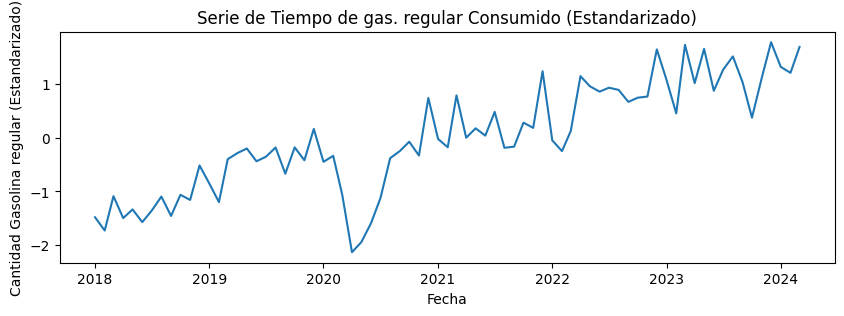

             Tipo     Valor      Fecha
0  Lectura Máxima  1.783135 2023-12-01
1  Lectura Mínima -2.133891 2020-04-01


In [4]:
cons_regular = df_con[['Fecha', 'Gasolina regular']].copy()

# Reemplazar abreviaturas de meses por números
cons_regular['Fecha'] = cons_regular['Fecha'].str.lower().replace(meses, regex=True)

# Convertir a datetime
cons_regular['Fecha'] = pd.to_datetime(cons_regular['Fecha'], format='%m/%Y')

# Limpiar y convertir la columna 'Gasolina regular'
cons_regular['Gasolina regular'] = cons_regular['Gasolina regular'].str.replace(',', '')
cons_regular['Gasolina regular'] = pd.to_numeric(cons_regular['Gasolina regular'], errors='raise')

start_date = '2018-01-01'
end_date = '2024-03-01'
cons_regular = cons_regular.loc[cons_regular['Fecha'] >= start_date]
cons_regular = cons_regular.loc[cons_regular['Fecha'] <= end_date]

# Standardize the 'Gasolina regular' column
scaler = StandardScaler()
cons_regular['Gasolina regular'] = scaler.fit_transform(cons_regular[['Gasolina regular']])

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(cons_regular['Fecha'], cons_regular['Gasolina regular'])
plt.title('Serie de Tiempo de gas. regular Consumido (Estandarizado)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Gasolina regular (Estandarizado)')
# plt.grid(True)
plt.show()

# Encontrar el valor máximo y mínimo
max_value = cons_regular['Gasolina regular'].max()
min_value = cons_regular['Gasolina regular'].min()

# Encontrar las fechas correspondientes al valor máximo y mínimo
max_date = cons_regular[cons_regular['Gasolina regular'] == max_value]['Fecha'].values[0]
min_date = cons_regular[cons_regular['Gasolina regular'] == min_value]['Fecha'].values[0]

# Crear la tabla
summary_table = pd.DataFrame({
    'Tipo': ['Lectura Máxima', 'Lectura Mínima'],
    'Valor': [max_value, min_value],
    'Fecha': [max_date, min_date]
})

# Mostrar la tabla
print(summary_table)

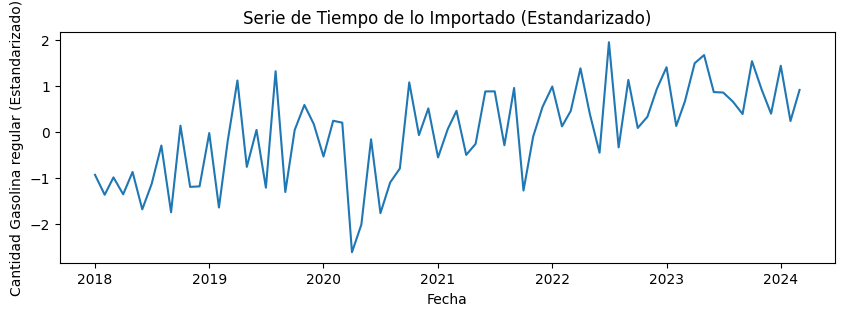

             Tipo     Valor      Fecha
0  Lectura Máxima  1.954351 2022-07-01
1  Lectura Mínima -2.617137 2020-04-01


In [5]:
# Crear una copia del DataFrame para trabajar con él
imp_regular = df_imp[['Fecha', 'Gasolina regular']].copy()

# Reemplazar abreviaturas de meses por números
imp_regular['Fecha'] = imp_regular['Fecha'].str.lower().replace(meses, regex=True)

# Convertir a datetime
imp_regular['Fecha'] = pd.to_datetime(imp_regular['Fecha'], format='%m/%Y')

# Limpiar y convertir la columna 'Gasolina regular'
imp_regular['Gasolina regular'] = imp_regular['Gasolina regular'].str.replace(',', '')
imp_regular['Gasolina regular'] = pd.to_numeric(imp_regular['Gasolina regular'], errors='raise')

start_date = '2018-01-01'
end_date = '2024-03-01'
imp_regular = imp_regular.loc[imp_regular['Fecha'] >= start_date]
imp_regular = imp_regular.loc[imp_regular['Fecha'] <= end_date]

# Standardize the 'Gasolina regular' column
scaler = StandardScaler()
imp_regular['Gasolina regular'] = scaler.fit_transform(imp_regular[['Gasolina regular']])

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(imp_regular['Fecha'], imp_regular['Gasolina regular'])
plt.title('Serie de Tiempo de lo Importado (Estandarizado)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Gasolina regular (Estandarizado)')
# plt.grid(True)
plt.show()

# Encontrar el valor máximo y mínimo
max_value = imp_regular['Gasolina regular'].max()
min_value = imp_regular['Gasolina regular'].min()

# Encontrar las fechas correspondientes al valor máximo y mínimo
max_date = imp_regular[imp_regular['Gasolina regular'] == max_value]['Fecha'].values[0]
min_date = imp_regular[imp_regular['Gasolina regular'] == min_value]['Fecha'].values[0]

# Crear la tabla
summary_table = pd.DataFrame({
    'Tipo': ['Lectura Máxima', 'Lectura Mínima'],
    'Valor': [max_value, min_value],
    'Fecha': [max_date, min_date]
})

# Mostrar la tabla
print(summary_table)

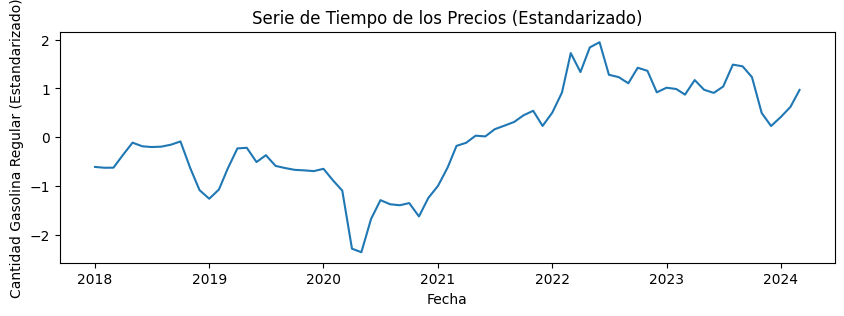

             Tipo     Valor      Fecha
0  Lectura Máxima  1.945971 2022-06-01
1  Lectura Mínima -2.352689 2020-05-01


In [6]:
# Crear una copia del DataFrame para trabajar con él
pre_regular = df_pre[['Fecha', 'Gasolina regular']].copy()

# Reemplazar abreviaturas de meses por números
pre_regular['Fecha'] = pre_regular['Fecha'].str.lower().replace(meses, regex=True)

# Convertir a datetime con el formato 'mm-yy'
pre_regular['Fecha'] = pd.to_datetime(pre_regular['Fecha'], format='%m-%y')

# Filtrar por el rango de fechas
start_date = '2018-01-01'
end_date = '2024-03-01'
pre_regular = pre_regular.loc[pre_regular['Fecha'] >= start_date]
pre_regular = pre_regular.loc[pre_regular['Fecha'] <= end_date]

# Aplicar la transformación logarítmica
pre_regular['Gasolina regular'] = np.log(pre_regular['Gasolina regular'] + 1)

# Standardize the 'Gasolina regular' column
scaler = StandardScaler()
pre_regular['Gasolina regular'] = scaler.fit_transform(pre_regular[['Gasolina regular']])

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(pre_regular["Fecha"], pre_regular["Gasolina regular"])
plt.title('Serie de Tiempo de los Precios (Estandarizado)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Gasolina Regular (Estandarizado)')
# plt.grid(True)
plt.show()

# Encontrar el valor máximo y mínimo
max_value = pre_regular['Gasolina regular'].max()
min_value = pre_regular['Gasolina regular'].min()

# Encontrar las fechas correspondientes al valor máximo y mínimo
max_date = pre_regular[pre_regular['Gasolina regular'] == max_value]['Fecha'].values[0]
min_date = pre_regular[pre_regular['Gasolina regular'] == min_value]['Fecha'].values[0]

# Crear la tabla
summary_table = pd.DataFrame({
    'Tipo': ['Lectura Máxima', 'Lectura Mínima'],
    'Valor': [max_value, min_value],
    'Fecha': [max_date, min_date]
})

# Mostrar la tabla
print(summary_table)

Para mantener estacionalidad se transformo el precio de la Gasolina Regular para que se acoplara y mantuviera la varianza constante para los modelos. 

## Modelo LSTM

### Consumo Gasolina Regular 

#### Primer Modelo

Separando los datos para entrenamiento y para prueba, en este caso se va partir 60% de entrenamiento,20% de validación y 20% de prueba

In [32]:
entrenamiento = round(0.6 * len(pre_regular))
val_prueba = round(0.2 * len(pre_regular))  # Assuming 20% for validation
test_size = len(pre_regular) - (entrenamiento + val_prueba)

# Ensure correct splitting of data
test = pre_regular[-test_size:]  # Last portion for testing

validation = pre_regular[entrenamiento:entrenamiento + val_prueba]  # Validation portion

train = pre_regular[:entrenamiento]  # Training portion
''''
# Reshape training data
train = np.reshape(train, (len(train), 1))'''
'''print(pre_regular.shape)
print(entrenamiento)
print(val_prueba)
print(test_size)'''
print(train.shape)

(45, 2)


Se tiene que generar una funcion para preparar los datos para LSTM

In [22]:

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)
max_seq_length = min(12, len(validation) - 1, len(test) - 1)
sequence_length = max_seq_length

print(f"Using sequence length: {sequence_length}")

X_train, y_train = create_sequences(train, sequence_length)
X_val, y_val = create_sequences(validation, sequence_length)
X_test, y_test = create_sequences(test, sequence_length)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 
  

Using sequence length: 12


InvalidIndexError: (slice(0, 12, None), 0)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices